In [1]:
%run functions.ipynb
from sklearn.neural_network import MLPClassifier

np.set_printoptions(precision=3)
np.random.seed(42)

%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
X_train, X_test, y_train, y_test = load_train_and_test_parts()
print("Train and test sizes: {} {}".format(X_train.shape, X_test.shape))
print(
    "(1, 0) labels count in train test: {} {}".format(
        (np.count_nonzero(y_train == 1), np.count_nonzero(y_train == 0)),
        (np.count_nonzero(y_test == 1), np.count_nonzero(y_test == 0)),
    )
)
standarizer = StandardScaler().fit(X_train)
X_std_train = standarizer.transform(X_train)
X_std_test = standarizer.transform(X_test)

Train and test sizes: (726, 12179) (243, 12179)
(1, 0) labels count in train test: (289, 437) (104, 139)


## Build random forest clasiefier and tree representation

Train and test scores: 0.8829201101928374 0.6995884773662552


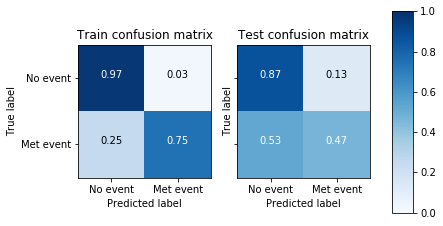

In [3]:
clf_forest = fit_clf(RandomForestClassifier(max_depth=4, n_estimators=500, min_samples_leaf=10), X_train, y_train, X_test, y_test)

In [4]:
def tree_representation(clf, data):
    result = np.zeros((data.shape[0], len(clf.estimators_)), dtype=np.int32)
    for i, tree in enumerate(clf.estimators_):
        result[:, i] = tree.predict(data)
    return result

In [5]:
X_tree_train = tree_representation(clf_forest, X_train)
X_tree_test = tree_representation(clf_forest, X_test)

## Test how this reduction works with basic models

Train and test scores: 0.9696969696969697 0.6872427983539094


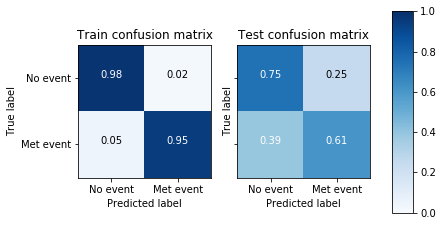

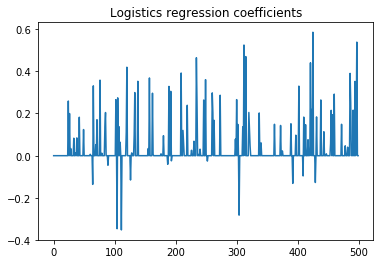

Train and test scores: 1.0 0.7160493827160493


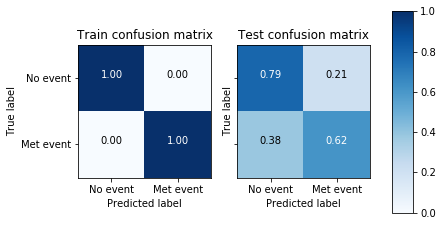

Train and test scores: 0.9421487603305785 0.7366255144032922


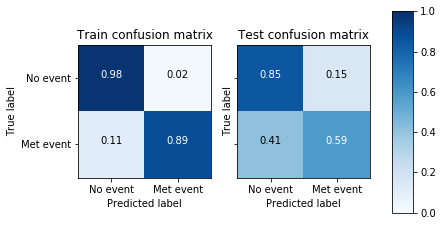

In [6]:
(clf_logit, clf_svm, clf_forest) = fit_models(X_tree_train, y_train, X_tree_test, y_test)

We will try [fDNN](https://www.nature.com/articles/s41598-018-34833-6) model

Train and test scores: 0.9077134986225895 0.7078189300411523


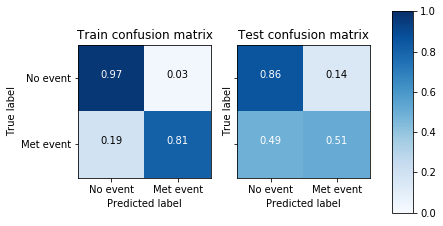

In [7]:
clf_nnet = MLPClassifier(hidden_layer_sizes=[X_tree_train.shape[1], 100], max_iter=1000, alpha=50)
clf_nnet = fit_clf(clf_nnet, X_tree_train, y_train, X_tree_test, y_test)